In [1]:
# Import 
import os
import time
import json
import random
import datetime
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path

from tyssue import config
from tyssue import Sheet

from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets

from tyssue.core.history import History 

from tyssue.dynamics import SheetModel as basemodel
from tyssue.dynamics import units, effectors, model_factory

from tyssue.solvers.quasistatic import QSSolver
from tyssue.solvers.viscous import EulerSolver

from tyssue.draw import sheet_view
from tyssue.draw import highlight_faces, create_gif
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 

from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet import actions, basic_events
#from tyssue.behaviors.sheet.apoptosis_events import apoptosis

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')


In [2]:
from polarity.dynamics import model, RadialTension
from polarity.dynamics import EllipsoidLameGeometry as geom

from polarity.apoptosis import apoptosis

from polarity.toolbox import (init,
                              define_fold_position,
                              apoptosis_ventral,
                              apoptosis_lateral,
                              apoptosis_dorsal,
                             )

In [3]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold_viscousSolver')

sim_save_dir = SIM_DIR

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [4]:
model = model_factory(
    [
        RadialTension,
        effectors.FaceContractility,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ], effectors.FaceAreaElasticity)

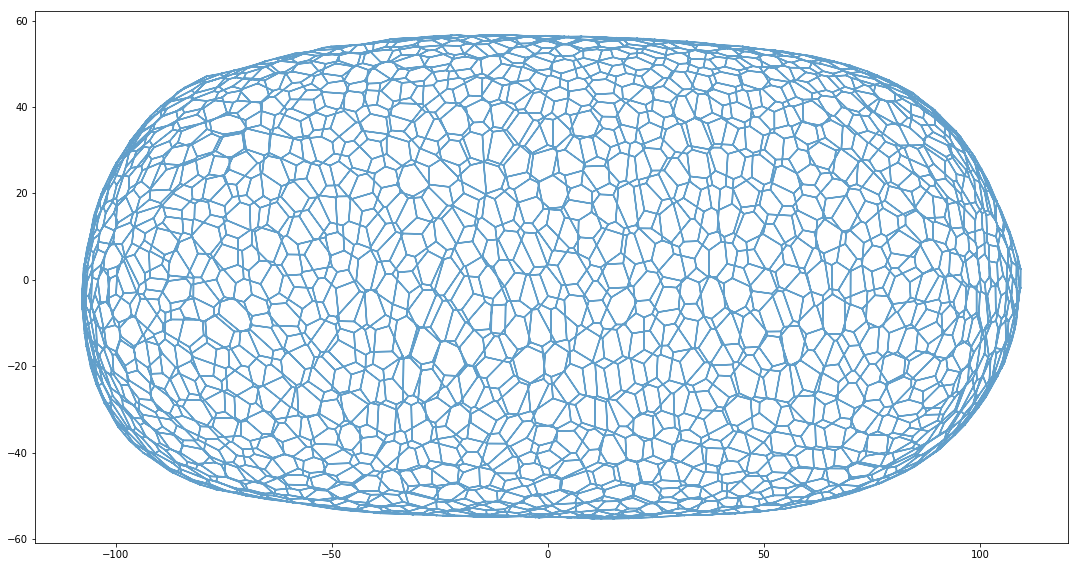

In [5]:
# Init superegg tissue 
sheet = init()

geom.update_all(sheet)

fig, ax = quick_edge_draw(sheet, ['z', 'x'],
                              alpha=0.7)

fig.set_size_inches(18.5, 10.5, forward=True)

### We first use quasistatic gradient descent to do a first return to equilibrium

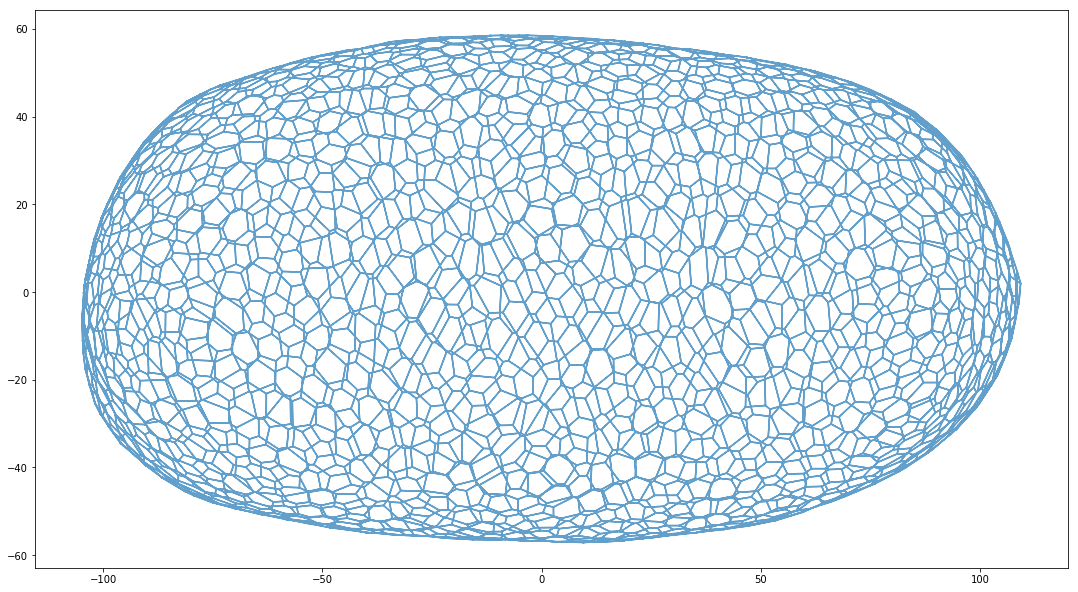

In [6]:
solver = QSSolver(with_t1=True, with_t3=False, with_collisions=False)
res = solver.find_energy_min(sheet, geom, model)
backupSheet = sheet.copy()

fig, ax = quick_edge_draw(sheet, ['z', 'x'],
                              alpha=0.7)
fig.set_size_inches(18.5, 10.5, forward=True)

In [7]:
sheet = backupSheet.copy()

In [8]:
"""import ipyvolume as ipv
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':sheet.vert_df.y*(sheet.vert_df.y>0),
                         'colormap':'viridis'})
fig"""
import ipyvolume as ipv
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'white'},
                      face={'color':'black', 'visible':True})
fig



Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0…

# Init basic information for fold formation

- position of the fold
- define 3 "categories" of apoptotic cells

In [9]:
define_fold_position(sheet, fold_number = 1, position=[-7, 7])
print(len(sheet.face_df[sheet.face_df.fold==1]))

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.fold,
                        'colormap':'Reds',
                        'visible':True})
fig


114


Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0…

In [10]:
sheet.face_df['apoptosis'] = 0
apoptosis_ventral(sheet, 1)
apoptosis_lateral(sheet, 1)
apoptosis_dorsal(sheet, 1)

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.apoptosis,
                        'colormap':'Reds',
                        'visible':True})
fig

print(len(sheet.face_df[sheet.face_df.fold>0]))
print(len(sheet.face_df[sheet.face_df.apoptosis>0]))
print(len(sheet.face_df[sheet.face_df.apoptosis==1]))
print(len(sheet.face_df[sheet.face_df.apoptosis==2]))
print(len(sheet.face_df[sheet.face_df.apoptosis==3]))
backupSheet2 = sheet.copy()

114
31
12
18
1


# Starting the viscous solver

In [11]:
# Initiate manager
manager = EventManager('face')

solver = EulerSolver(
    sheet,
    geom, 
    model,
    manager = manager,
    bounds = (-sheet.edge_df.length.median()/10,
        sheet.edge_df.length.median()/10)
    )

manager.update()
sheet.vert_df['viscosity'] = 0.1

In [25]:
def save_sheet(history, path="", start_number = 0., dt = 0.1):
    times = history.time_stamps.shape[0]
    i = start_number
    for t in range(times):
        sheet = history.retrieve(t)
        hdf5.save_datasets(path+'../../test/movie_{:.2f}.hf5'.format(i), sheet)
        i+=dt
        

def run_sim(sim_save_dir, sheet, constriction, radial_tension, iteration=0):
    
    dirname = '{}_constriction_{}_radialtension{}'.format(
        constriction,radial_tension, iteration)
    dirname = os.path.join(sim_save_dir, dirname)
    
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass
    
    apoptosis_settings = {
        "critical_area": 0.5,
        "contract_rate": constriction,
        "basal_contract_rate": 1.01,
        "shrink_span": 2,
        "radial_tension": radial_tension,
        "max_traction":30,
        "current_traction":0,
        "geom": geom,
    }

    # Add some information to the sheet and copy initial sheet
    sheet2 = sheet.copy(deep_copy=True)
    sheet2.face_df['id'] = sheet2.face_df.index.values
    sheet2.face_df['critical_area']=0.5
    sheet2.settings['apoptosis'] = apoptosis_settings
    

    #sheet2 = apoptosis_process(dirname, solver, sheet2)
    
    # Initiate manager
    manager = EventManager('face')
    manager.append(basic_events.reconnect)
    
    #Initiate history to save all columns in all df
    history = History(sheet2, extra_cols={"face": sheet2.face_df.columns,
                                          "edge": list(sheet2.edge_df.columns),
                                          "vert": list(sheet2.vert_df.columns)
                                         })
    
    # Starting viscous solver
    solver = EulerSolver(
    sheet2,
    geom, 
    model,
    history =history,
    manager = manager,
    bounds = (-sheet2.edge_df.length.median()/10,
        sheet2.edge_df.length.median()/10)
    )

    manager.update()
    sheet2.vert_df['viscosity'] = 0.1
    
    
    # Solving part... 
    # test in progress...
    dt = 0.1
    sheet2.settings["dt"] = dt
    
    # 1sec simulation with no action
    solver.solve(1-dt, dt)
    
    save_sheet(solver.history, start_number=0, dt=dt)
    
    # Add first wave of apoptotic cells
    apopto_cell = sheet2.face_df[sheet2.face_df.apoptosis == 1].id
    
    #for c in apopto_cell[0] :     
    for c in apopto_cell[:4].values:
        apopto_kwargs = sheet2.settings['apoptosis'].copy()
        apopto_kwargs.update(
        {
            #'face_id': int(c),
            'face_id':int(c),
        }
        )
        manager.append(apoptosis, **apopto_kwargs)
    manager.update()
     
    # 10sec simulation with first wave of apoptosis
    solver.solve(1-dt, dt)
    save_sheet(solver.history, start_number = 1, dt = 0.1)
    solver.solve(1-dt, dt)
    save_sheet(solver.history, start_number = 2, dt = 0.1)
    
    print(solver.history.time_stamps.shape)
    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')
    return sheet2, solver

In [26]:
from datetime import datetime
global_start=datetime.now()
print ("start : " + str(global_start))
sheet= backupSheet2.copy()
sheet_out, solver_out=run_sim(sim_save_dir, sheet, 1.08, 50000, 0)
global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

start : 2019-08-08 14:47:05.694905
starting /home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold_viscousSolver/1.08_constriction_50000_radialtension0
(10,)
/home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold_viscousSolver/1.08_constriction_50000_radialtension0 done
~~~~~~~~~~~~~~~~~~~~~

end : 2019-08-08 14:47:10.281069
Duree totale d execution : 
		
0:00:04.586164


In [14]:
dsfsdf

NameError: name 'dsfsdf' is not defined

In [ ]:
solver_out.history.retrieve(40)

In [27]:
sheet_ = solver_out.history.retrieve(0)
previous =sheet_.face_df[sheet_.face_df.apoptosis == 1].area 

for i in range (solver_out.history.time_stamps.shape[0]):
    sheet_ = solver_out.history.retrieve(i)
    print('____________')
    print(i)
    current = sheet_.face_df[sheet_.face_df.apoptosis == 1].area 
    print(pd.DataFrame([(previous-current).values, current.values]))
    previous = current

____________
0
          0          1          2          3          4          5   \
0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1  45.244306  50.653551  31.724897  51.761491  44.972422  45.631554   

          6          7          8          9          10         11  
0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000  
1  47.665721  41.317609  47.270503  36.359936  53.810709  40.243733  
____________
1
          0          1          2          3          4          5   \
0   0.086979   0.102730   0.043105   0.104312  -0.015839  -0.006771   
1  45.157326  50.550821  31.681793  51.657179  44.988261  45.638325   

          6          7          8          9          10         11  
0  -0.009640   0.002425  -0.015330  -0.084771  -0.010909  -0.003991  
1  47.675361  41.315184  47.285833  36.444707  53.821618  40.247724  
____________
2
          0          1          2          3          4          5   \
0   0.000000   0.000000   0.000000  

In [ ]:
eerterg

In [ ]:
""""def apoptosis_process(dirname, solver, sheet):
    
    
    
    t = 0
    stop = 150
        
    # Run simulation
    while t < stop:
        if t%10 == 0:
            sheet.settings['lumen_prefered_vol'] *= 0.99        
        
        # Reset radial tension at each time step
        sheet.vert_df.radial_tension = 0
        
        # Add face in apoptosis according to the 
        # spatio-temporal patterning define previously
        if t == 1 :
            apopto_cell = sheet.face_df[sheet.face_df.apoptosis == 1].id
            for c in apopto_cell : 
                apopto_kwargs = sheet.settings['apoptosis'].copy()
                apopto_kwargs.update(
                {
                    'face_id': c,
                }
                )
                manager.append(apoptosis, **apopto_kwargs)
        
        if t == 11 : 
            apopto_cell = sheet.face_df[sheet.face_df.apoptosis == 2].id
            for c in apopto_cell : 
                apopto_kwargs = sheet.settings['apoptosis'].copy()
                apopto_kwargs.update(
                {
                    'face_id': c,
                    "max_traction":30,
                    "current_traction":0,
                }
                )
                manager.append(apoptosis, **apopto_kwargs)
                
        if t == 21:
            apopto_cell = sheet.face_df[sheet.face_df.apoptosis == 3].id
            for c in apopto_cell : 
                apopto_kwargs = sheet.settings['apoptosis'].copy()
                apopto_kwargs.update(
                {
                    'face_id': c,
                    "max_traction":30,
                    "current_traction":0,
                }
                )
                manager.append(apoptosis, **apopto_kwargs)
        
        manager.execute(sheet)
        
        res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

        # add noise on vertex position to avoid local minimal.
        sheet.vert_df[
            ['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
        geom.update_all(sheet)
        
    
        
        # Save result in each time step.
        figname = os.path.join(
            dirname, 'invagination_{:04d}.png'.format(t))
        hdfname = figname[:-3] + 'hf5'
        
        
        with pd.HDFStore(hdfname) as test:
            test.put("settings", pd.Series(sheet.settings))

        with pd.HDFStore(hdfname) as store:
            settings = store['settings']
        
        hdf5.save_datasets(hdfname, sheet)



        manager.update()
        t += 1

    return sheet
"""

In [ ]:
# Sequential Execution

from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))

radial_tension = [50]
contractility_percent = [8]
contractility_rate = [1+c/100 for c in contractility_percent]

for c in contractility_rate:
    for rd in radial_tension:
        for iteration in range (0, 1):
            run_sim(sim_save_dir, sheet, c, rd, iteration)
        
        
        
global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

In [ ]:
ipv.clear()
eptm = sheet2.copy()
geom.update_all(eptm)
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible":True,
        "color": eptm.face_df['area'],
    }
    
)
ipv.squarelim()
ipv.show()

In [ ]:
def custom_view(eptm, ax=None, coords=['z', 'x']):
    geom.update_all(eptm)
    eptm.face_df['lock'] = True
    specs = {
        "edge":
        {
            "visible" : False,
        },
        "vert" :
        {
            "visible": False
        },
        "face":
        {
            "visible":True,
            "color": eptm.face_df['area']*(1.0 - eptm.face_df['lock'].astype(float)),
            "color_range": (
                eptm.face_df['area'].quantile(0.1),
                eptm.face_df['area'].quantile(0.9)
                )
        }      
    }
    eptm.face_df["visible"] = eptm.face_df.y > -0.1
    fig, ax = sheet_view(eptm, coords=coords, mode="2D", ax=ax, **specs)
    ax.set_xlim(-10, 10)
    fig.set_size_inches(12, 4)
    return fig, ax

In [ ]:
create_gif(
    solver.history,
    "../data/tube.gif",
    num_frames=200,
    margin=2,
    coords=['z', 'x'],
    draw_func=custom_view)

In [ ]:
solver.history